In [1]:
from pathlib import Path
from Bio.PDB import PDBList, PDBParser
import os
from tqdm import tqdm
import warnings
import pandas as pd
from Bio import SeqIO
from dotenv import load_dotenv
import os
import requests
import time
import json
from Bio.PDB.ic_rebuild import structure_rebuild_test
import numpy as np
import sys
import seaborn as sns

load_dotenv()

True

In [3]:
WINDOW_SIZE = 3
PDBMINE_URL = os.getenv("PDBMINE_URL")
casp_protein_id = 'T1024'
pdb_code = '6t1z'

In [4]:
amino_acid_codes = {
    "ALA": "A",
    "ARG": "R",
    "ASN": "N",
    "ASP": "D",
    "CYS": "C",
    "GLN": "Q",
    "GLU": "E",
    "GLY": "G",
    "HIS": "H",
    "ILE": "I",
    "LEU": "L",
    "LYS": "K",
    "MET": "M",
    "PHE": "F",
    "PRO": "P",
    "SER": "S",
    "THR": "T",
    "TRP": "W",
    "TYR": "Y",
    "VAL": "V"
}

In [7]:
# Get X-ray pdb
pdbl = PDBList()
parser = PDBParser()
xray_fn = pdbl.retrieve_pdb_file(pdb_code, pdir='pdb', file_format='pdb', obsolete=False)

# Get CASP predictions
predictions_url = f'https://predictioncenter.org/download_area/CASP14/predictions/regular/{casp_protein_id}.tar.gz'
predictions_dir = Path(f'./casp-predictions/')
predictions_dir.mkdir(exist_ok=True)
# os.system(f'wget -O {predictions_dir}/{casp_protein_id}.tar.gz {predictions_url}')
# os.system(f'tar -xvf {predictions_dir}/{casp_protein_id}.tar.gz -C {predictions_dir}')

# Get CASP results
results_url = 'https://predictioncenter.org/download_area/CASP14/results/tables/casp14.res_tables.T.tar.gz'
results_dir = Path('casp-results')
results_dir.mkdir(exist_ok=True)
# os.system(f'wget -O {results_dir / "casp14.res_tables.T.tar.gz"} {results_url}')
# os.system(f'tar -xvf {results_dir / "casp14.res_tables.T.tar.gz"} -C {results_dir}')
results_file = results_dir / f'{casp_protein_id}.txt'

Structure exists: 'pdb/pdb6t1z.ent' 


--2024-04-11 13:11:17--  https://predictioncenter.org/download_area/CASP14/predictions/regular/T1024.tar.gz
Resolving predictioncenter.org (predictioncenter.org)... 128.120.136.155
Connecting to predictioncenter.org (predictioncenter.org)|128.120.136.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28668808 (27M) [application/x-gzip]
Saving to: ‘casp-predictions/T1024.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  244K 1m55s
    50K .......... .......... .......... .......... ..........  0%  439K 89s
   100K .......... .......... .......... .......... ..........  0%  577K 75s
   150K .......... .......... .......... .......... ..........  0%  380K 75s
   200K .......... .......... .......... .......... ..........  0% 35.5M 60s
   250K .......... .......... .......... .......... ..........  1% 7.38M 50s
   300K .......... .......... .......... .......... ..........  1%  754K 48s
   350K .......... .......... .......... .........

In [8]:
# Get structures
xray = parser.get_structure(pdb_code, xray_fn)

predicted_structures = []
for prediction_pdb in tqdm((predictions_dir / casp_protein_id).iterdir()):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        predicted_structures.append(parser.get_structure(prediction_pdb.name, prediction_pdb))

512it [00:23, 21.62it/s]


In [9]:
results = pd.read_csv(results_file, delim_whitespace=True)
results = results[results.columns[1:]]

/var/folders/pr/kj9ky04n4_q058ntx_2k9y540000gn/T/ipykernel_40495/1205245770.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  results = pd.read_csv(results_file, delim_whitespace=True)


In [51]:
# Get Phi-Psi distribution from PDBMine
for record in SeqIO.parse(xray_fn, "pdb-seqres"):
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    print(record)
residue_chain = str(record.seq)
code_length = 1
broken_chains = []
# break into sections of length 100
for i in range(0, len(residue_chain), 100-WINDOW_SIZE+1):
    broken_chains.append(residue_chain[i:i+100])

matches = {}
for chain in tqdm(broken_chains):
    if len(chain) < WINDOW_SIZE:
        continue
    response = requests.post(
        PDBMINE_URL + '/v1/api/query',
        json={
            "residueChain": chain,
            "codeLength": code_length,
            "windowSize": WINDOW_SIZE
        }
    )
    assert(response.ok)
    print(response.json())
    query_id = response.json().get('queryID')
    assert(query_id)

    time.sleep(15)
    while(True):
        response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
        if response.ok:
            matchesi = response.json()['frames']
            break
        else:
            print('Waiting')
            time.sleep(15)
    print('Received matches')
    matches.update(matchesi)
json.dump(matches, open('matches.json', 'w'), indent=4)

Record id 6T1Z:A, chain A
ID: 6T1Z:A
Name: 6T1Z:A
Description: UNP:Q48658 Q48658_9LACT
Database cross-references: UNP:Q48658, UNP:Q48658_9LACT
Number of features: 0
/chain=A
/molecule_type=protein
Seq('GKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAV...FQG')


  0%|          | 0/5 [00:00<?, ?it/s]

{'status': 'Running', 'queryID': 'e2d24f29-f817-11ee-9841-0242ac110002'}
Waiting
Waiting
Waiting


 20%|██        | 1/5 [01:42<06:51, 102.82s/it]

Received matches
{'status': 'Running', 'queryID': '201be30f-f818-11ee-9841-0242ac110002'}
Waiting
Waiting
Waiting


 40%|████      | 2/5 [03:17<04:54, 98.26s/it] 

Received matches
{'status': 'Running', 'queryID': '58c5d5d5-f818-11ee-9841-0242ac110002'}
Waiting
Waiting
Waiting


 60%|██████    | 3/5 [04:45<03:07, 93.57s/it]

Received matches
{'status': 'Running', 'queryID': '8d36c06b-f818-11ee-9841-0242ac110002'}
Waiting
Waiting
Waiting


 80%|████████  | 4/5 [06:28<01:37, 97.11s/it]

Received matches
{'status': 'Running', 'queryID': 'ca54789b-f818-11ee-9841-0242ac110002'}


100%|██████████| 5/5 [06:48<00:00, 81.68s/it]

Received matches


## Collect by Window

In [17]:
matches = json.load(open('matches.json'))

In [7]:
# Get phi-psi by window
phi_psi_mined_by_window_ = []
for seq_win,v in matches.items():
    seq = seq_win#[4:]
    for protein,seq_matches in v.items():
        protein_id, chain = protein.split('_')
        if protein_id.lower() == pdb_code.lower(): # skip the protein we're looking at
            continue
        for seq_match in seq_matches:
            center_res = seq_match[WINDOW_SIZE//2]
            res, phi, psi = center_res.values()
            phi_psi_mined_by_window_.append([seq, res, phi, psi, chain, protein_id])
phi_psi_mined_by_window = pd.DataFrame(phi_psi_mined_by_window_, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
phi_psi_mined_by_window.to_csv('phi_psi_mined_by_window.csv', index=False)

In [7]:
phi_psi_mined_by_window = pd.read_csv('phi_psi_mined_by_window.csv')

In [ ]:
# Get phi_psi's of each prediction

def get_phi_psi_by_window(protein_id, protein):
    phi_psi_ = []
    chain = list(prediction[0].get_chains())[0]
    chain.atom_to_internal_coordinates(verbose=False)
    resultDict = structure_rebuild_test(chain)
    if not resultDict['pass']:
        raise Exception(f'Failed to rebuild {protein_id} {chain.id}')
    residues = list(chain.get_residues())
    for i in range(WINDOW_SIZE//2, len(residues) - WINDOW_SIZE // 2):
        # Convert 3 char codes to 1 char codes
        seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i-WINDOW_SIZE//2:i+WINDOW_SIZE//2+1]])
        res = seq[WINDOW_SIZE//2]
        if not residues[i].internal_coord:
            psi,phi = np.nan, np.nan
        else:
            psi = residues[i].internal_coord.get_angle("psi")
            phi = residues[i].internal_coord.get_angle("phi")
            psi = psi if psi else np.nan # if psi is None, set it to np.nan
            phi = phi if phi else np.nan # if phi is None, set it to np.nan
        phi_psi_.append([seq, res, phi, psi, chain.id, protein.id])
    return phi_psi_

phi_psi_predictions_ = []
for prediction in tqdm(predicted_structures):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            phi_psi_predictions_ += get_phi_psi_by_window(prediction.id, prediction)
        except Exception as e:
            print(e)
phi_psi_predictions_by_window = pd.DataFrame(phi_psi_predictions_, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
# phi_psi_predictions_by_window.to_csv('phi_psi_predictions_by_window.csv', index=False)

In [58]:
xray_structure = parser.get_structure(pdb_code, xray_fn)
xray_chain = list(xray_structure[0].get_chains())[0]
xray_chain.atom_to_internal_coordinates(verbose=False)
resultDict = structure_rebuild_test(xray_chain)
if not resultDict['pass']:
    raise Exception('Failed to rebuild')
xray_residues = list(xray_chain.get_residues())
xray_phi_psi = []
for i in range(WINDOW_SIZE//2, len(xray_residues) - WINDOW_SIZE // 2):
    # Convert 3 char codes to 1 char codes
    seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in xray_residues[i-WINDOW_SIZE//2:i+WINDOW_SIZE//2+1]])
    res = seq[WINDOW_SIZE//2]
    if not xray_residues[i].internal_coord:
        psi,phi = np.nan, np.nan
    else:
        psi = xray_residues[i].internal_coord.get_angle("psi")
        phi = xray_residues[i].internal_coord.get_angle("phi")
        psi = psi if psi else np.nan # if psi is None, set it to np.nan
        phi = phi if phi else np.nan # if phi is None, set it to np.nan
    xray_phi_psi.append([seq, res, phi, psi, xray_chain.id, xray_structure.id])
xray_phi_psi = pd.DataFrame(xray_phi_psi, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])

# Results - By Window

In [11]:
phi_psi_mined_by_window = pd.read_csv('windowsize5/phi_psi_mined_by_window.csv')
phi_psi_predictions_by_window = pd.read_csv('windowsize5/phi_psi_predictions_by_window.csv')
phi_psi_mined_by_window['source'] = 'Query (PDBMine)'
phi_psi_predictions_by_window['source'] = 'Prediction'

In [47]:
for record in SeqIO.parse(xray_fn, "pdb-seqres"):
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    print(record)
residue_chain = str(record.seq)

Record id 6T1Z:A, chain A
ID: 6T1Z:A
Name: 6T1Z:A
Description: UNP:Q48658 Q48658_9LACT
Database cross-references: UNP:Q48658, UNP:Q48658_9LACT
Number of features: 0
/chain=A
/molecule_type=protein
Seq('GKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAV...FQG')


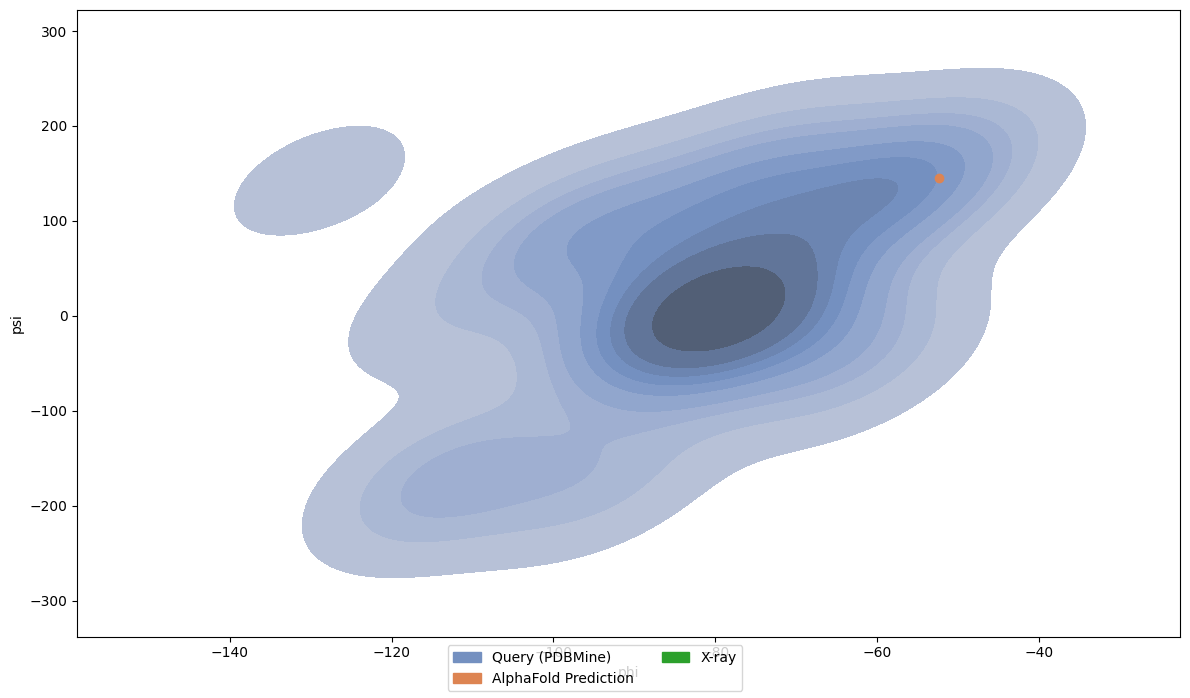

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, axes = plt.subplots(figsize=(12,7))

seq = phi_psi_mined_by_window.seq.unique()[5]
phi_psi_dist = phi_psi_mined_by_window[phi_psi_mined_by_window.seq == seq]
phi_psi_alpha = phi_psi_predictions_by_window[(phi_psi_predictions_by_window.protein_id == 'T1024TS427_1') & (phi_psi_predictions_by_window.seq == seq)]
xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq == seq]
sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=axes, fill=True, color='#7490c0', legend=True)
plt.plot(phi_psi_alpha.phi, phi_psi_alpha.psi, 'o', color='#dd8452', label='Prediction')
plt.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color='tab:green', label='X-ray')
# # legend on bottom middle
patch1 = mpatches.Patch(color='#7490c0', label='Query (PDBMine)')
patch2 = mpatches.Patch(color='#dd8452', label='AlphaFold Prediction')
patch3 = mpatches.Patch(color='tab:green', label='X-ray')
fig.legend(handles=[patch1, patch2, patch3], loc='lower center', ncol=2)
# fig.suptitle(f'Distribution of phi, psi angles for the residues in {protein_id_pdb}')
plt.tight_layout()

xray: 0.3179641408942607
alpha: 0.7166476298057972
preds:                  0
count   423.000000
mean     13.323615
std      89.302861
min       0.001910
25%       0.172834
50%       0.356789
75%       0.995211
max    1342.079269


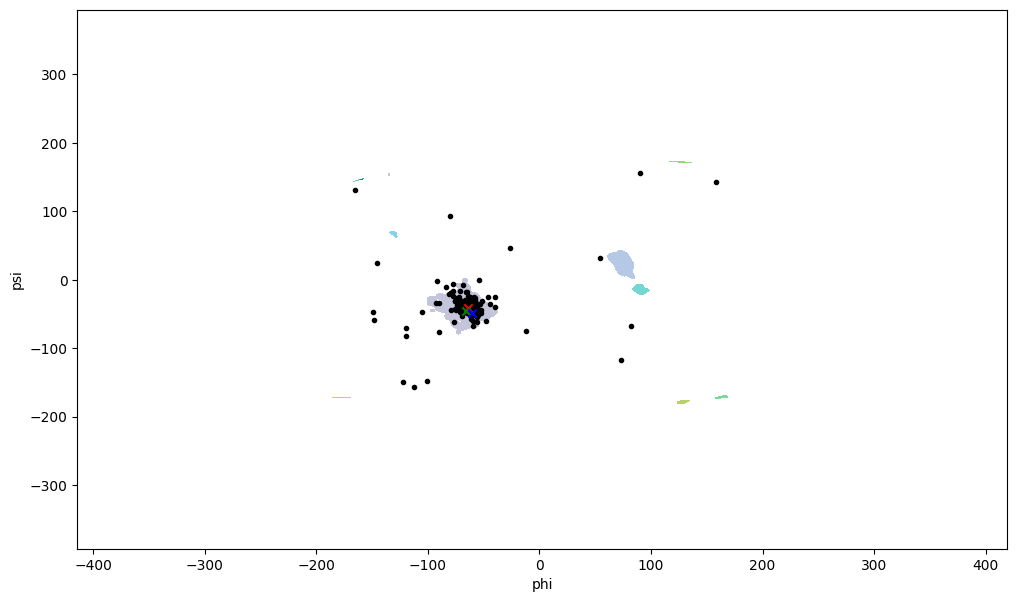

In [95]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

seq = 'LAGLL'
phi_psi_dist = phi_psi_mined_by_window.loc[phi_psi_mined_by_window.seq == seq][['phi','psi']]

# Find most popular cluster
clustering = DBSCAN(eps=10, min_samples=3).fit(phi_psi_dist.values)
phi_psi_dist['cluster'] = clustering.labels_
most_common = phi_psi_dist['cluster'].value_counts().idxmax()
phi_psi_c = phi_psi_dist.loc[phi_psi_dist.cluster == most_common, ['phi','psi']].values

# Find mahalanobis distance of xray to most common cluster
cov = np.cov(phi_psi_c.T)
icov = np.linalg.inv(cov)

xray = xray_phi_psi[xray_phi_psi.seq == seq][['phi','psi']].values
md_xray = (xray - phi_psi_c.mean(axis=0)) @ icov @ (xray - phi_psi_c.mean(axis=0)).T

# Find mahalanobis distance of alpha to most common cluster
alpha = phi_psi_predictions_by_window[(phi_psi_predictions_by_window.protein_id == 'T1024TS427_1') & (phi_psi_predictions_by_window.seq == seq)][['phi','psi']].values
md_alpha = (alpha - phi_psi_c.mean(axis=0)) @ icov @ (alpha - phi_psi_c.mean(axis=0)).T

# FInd mahanobis distance of other predictions
preds = phi_psi_predictions_by_window[phi_psi_predictions_by_window.seq == seq][['phi','psi']].values
icov = np.repeat(np.expand_dims(icov, 0), preds.shape[0], axis=0) # expand for batch matrix multiplication
md_preds = md = (np.expand_dims((preds - phi_psi_c.mean(axis=0)), 1) @ icov @ np.expand_dims((preds - phi_psi_c.mean(axis=0)), 2)).squeeze()

mean = phi_psi_c.mean(axis=0)
fig, ax = plt.subplots(figsize=(12,7))
sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', hue='cluster', palette='viridis', ax=ax, fill=True, legend=False)
ax.scatter(preds[:,0], preds[:,1], color='black', marker='.')
ax.scatter(mean[0], mean[1], color='red', marker='x')
ax.scatter(xray[0,0], xray[0,1], color='green', marker='x')
ax.scatter(alpha[0,0], alpha[0,1], color='blue', marker='x')

ax.s

print('xray:', md_xray[0,0])
print('alpha:', md_alpha[0,0])
print('preds:', pd.DataFrame(md_preds).describe())

In [297]:
phi_psi_predictions_by_window['mahalanobis_dist'] = np.nan
for seq in phi_psi_mined_by_window.seq.unique():
    phi_psi = phi_psi_mined_by_window[phi_psi_mined_by_window.seq == seq][['phi','psi']].dropna().values
    if phi_psi.shape[0] < 2:
        continue
    cov = np.cov(phi_psi.T)
    if np.linalg.det(cov) == 0:
        continue
    icov_ = np.linalg.inv(cov)
    preds = phi_psi_predictions_by_window.loc[phi_psi_predictions_by_window.seq == seq][['phi','psi']].values
    icov = np.repeat(np.expand_dims(icov_, 0), preds.shape[0], axis=0) # expand for batch matrix multiplication
    md = (np.expand_dims((preds - phi_psi.mean(axis=0)), 1) @ icov @ np.expand_dims((preds - phi_psi.mean(axis=0)), 2)).squeeze()
    if np.any(md < 0):
        continue
    md = np.sqrt(md)
    phi_psi_predictions_by_window.loc[phi_psi_predictions_by_window.seq == seq, 'mahalanobis_dist'] = md

    # for xray
    # preds = xray_phi_psi.loc[xray_phi_psi.seq == seq][['phi','psi']].values # Should only be one of these
    # icov = icov_
    # md = (preds - phi_psi.mean(axis=0)) @ icov @ (preds - phi_psi.mean(axis=0)).T
    # if np.any(md < 0):
    #     continue
    # md = np.sqrt(md)
    # print(preds.shape, md.shape)
    # xray_phi_psi.loc[xray_phi_psi.seq == seq, 'mahalanobis_dist'] = md

In [313]:
phi_psi_predictions_by_window.to_csv('phi_psi_predictions_by_window_maha.csv', index=False)

In [345]:
group_maha

,protein_id,phi,psi,mahalanobis_dist,Model,RMS_ALL
0,T1024TS004_1,-28190.444943,-3252.197094,8.484913e+09,T1024TS004_1,25.296
1,T1024TS004_2,-28146.523142,-3234.629680,8.488801e+09,T1024TS004_2,22.468
2,T1024TS004_3,-28152.504328,-3301.725501,8.493832e+09,T1024TS004_3,25.095
3,T1024TS004_4,-28150.105770,-3455.868714,8.487125e+09,T1024TS004_4,42.649
4,T1024TS004_5,-28107.101504,-3439.023820,8.484714e+09,T1024TS004_5,40.184
...,...,...,...,...,...,...
479,T1024TS498_1,-27303.409984,-10426.315166,1.483601e+10,T1024TS498_1,4.560
480,T1024TS498_2,-26693.264252,-9990.391627,1.423974e+10,T1024TS498_2,4.074
481,T1024TS498_3,-26061.115368,-9936.279381,1.397413e+10,T1024TS498_3,4.083
482,T1024TS498_4,-25750.823561,-10621.087916,1.401125e+10,T1024TS498_4,4.094


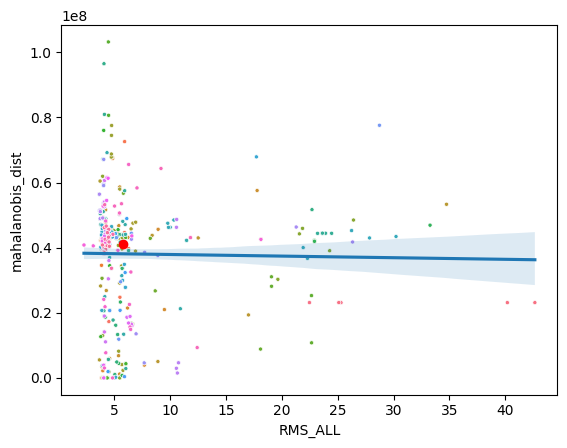

In [348]:
# Compare rmsd and mahalanobis distance
import matplotlib.pyplot as plt
group_maha = phi_psi_predictions_by_window.groupby(['protein_id'], as_index=False).mean(numeric_only=True)#.sort_values('mahalanobis_dist').set_index('protein_id').dropna()
group_maha = group_maha.merge(results[['Model', 'RMS_ALL']], left_on='protein_id', right_on='Model', how='inner')
group_maha
fig, ax = plt.subplots()
sns.scatterplot(data=group_maha, x='RMS_ALL', y='mahalanobis_dist', ax=ax, marker='.', hue='protein_id', legend=False)
sns.regplot(data=group_maha, x='RMS_ALL', y='mahalanobis_dist', ax=ax, scatter=False)
plt.plot(group_maha[group_maha.protein_id == 'T1024TS427_1']['RMS_ALL'], group_maha[group_maha.protein_id == 'T1024TS427_1']['mahalanobis_dist'], 'o', color='red', label='Alphafold')
# # ax.set_xlim((0.8,1.4))
# ax.set_ylim((0,6))

(2, 7)
(8, 7)
(5, 7)
(8, 7)


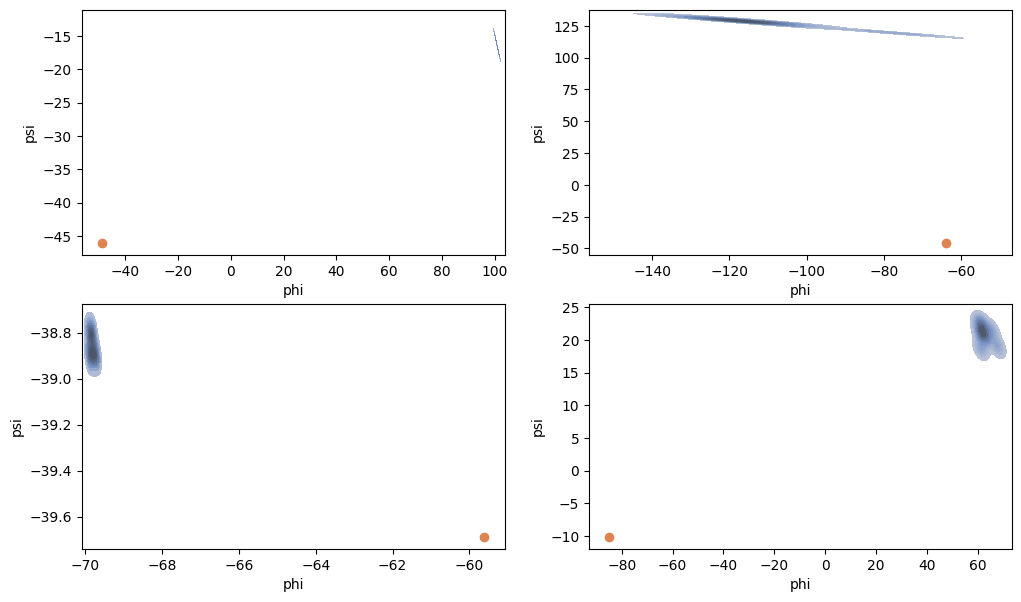

In [362]:
# plot dists with highest mahalanobis distance for alphafold
phi_psi_alpha = phi_psi_predictions_by_window[phi_psi_predictions_by_window.protein_id == 'T1024TS427_1']
seqs_with_highest_maha = phi_psi_alpha.sort_values('mahalanobis_dist', ascending=False).head(16).seq.values

m = 0
fig, axes = plt.subplots(2,2,figsize=(12,7))
for i,seq in enumerate(seqs_with_highest_maha[m:m+4]):
    phi_psi_dist = phi_psi_mined_by_window[phi_psi_mined_by_window.seq == seq]
    print(phi_psi_dist.shape)
    phi_psi_alpha_seq = phi_psi_alpha[phi_psi_alpha.seq == seq]
    ax = axes.flatten()[i]
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
    ax.plot(phi_psi_alpha_seq.phi, phi_psi_alpha_seq.psi, 'o', color='#dd8452', label='Prediction')
